In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from pyret.nonlinearities import Binterp, Sigmoid
from torchdeepretina.utils import *
import torchdeepretina.stimuli as stim
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TrainDataset
from kinetic.utils import normalize_filter2

In [42]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack3')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_015_loss_-10.00_pearson_0.5823.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_010_loss_-3.03_pearson_0.6187.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_NoNorm/epoch_035_loss_-8.35_pearson_0.6626.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

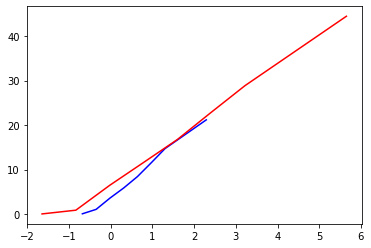

In [68]:
device = torch.device('cuda:0')
filt_depth = 40
nrepeats = 30
cells='all'
filter_len = 100
cell = 0
with torch.no_grad():
    for contrast in [0.5, 1.2]:
        x = np.random.randn(1347,50,50) * contrast
        x = np.repeat(x, 3, axis=0)
        stimulus = x
        x = 2.37 * x
         
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        
        layer_outs = inspect(model, x)
        responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


        resp = responses[:, cell]
        sta, _ = pyret.filtertools.revcorr(stimulus, scipy.stats.zscore(resp), 0, filter_len)
        #sta, _ = pyret.filtertools.revcorr(stimulus, resp, 0, filter_len)
        sta = np.flip(sta, axis=0)
        sta -= sta.mean()

        #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
        normed_sta = normalize_filter2(sta, stimulus)

        filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
        nonlinearity = Binterp(40)
        #nonlinearity = Sigmoid(peak=100.)
        nonlinearity.fit(filtered_stim[filter_len:], resp[filter_len:])

        x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
        nonlinear_prediction = nonlinearity.predict(x)
        spatial, temporal = ft.decompose(normed_sta)

        if contrast == 0.5:
            plt.plot(x, nonlinear_prediction, 'b-')
        else:
            plt.plot(x, nonlinear_prediction, 'r-')
    plt.show()

In [8]:
TrainDataset(cfg).stats

{'mean': 51.80844618169092, 'std': 53.91593799373168}

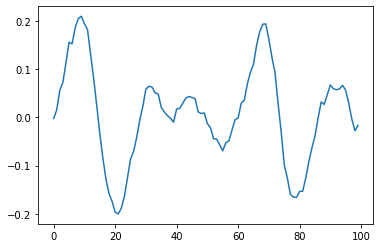

In [28]:
spatial, temporal = ft.decompose(normed_sta)
plt.plot(temporal)

In [37]:
sta = compute_sta(model, 0.3, layer='ganglion', cell_index=0, verbose=False)

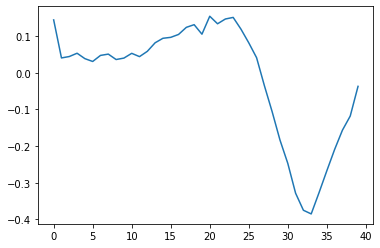

In [41]:
spatial, temporal = ft.decompose(sta)
plt.plot(temporal)

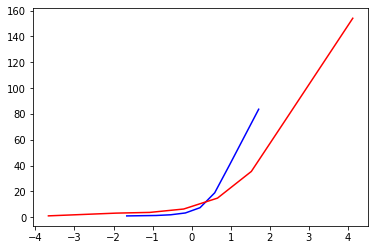

In [79]:
device = torch.device('cuda:0')
filt_depth = 40
cells='all'
cell = 0

for contrast in [0.5, 1.2]:
    x = np.random.randn(1347,50,50) * contrast
    x = np.repeat(x, 3, axis=0)
    stimulus = x
    x = (x + 1) * 127.5
    x = (x - 51.8)/53.9

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
    
    layer_outs = inspect(model, x)
    responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))

    resp = responses[:, cell]
    sta = compute_sta(model, contrast, layer='ganglion', cell_index=cell, verbose=False)
    sta = np.flip(sta, axis=0)
    sta -= sta.mean()

    #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
    normed_sta = normalize_filter2(sta, stimulus)

    filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
    nonlinearity = Binterp(10)
    #nonlinearity = Sigmoid(peak=100.)
    nonlinearity.fit(filtered_stim[filter_len:], resp[filter_len:])

    x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
    nonlinear_prediction = nonlinearity.predict(x)
    spatial, temporal = ft.decompose(normed_sta)

    if contrast == 0.5:
        plt.plot(x, nonlinear_prediction, 'b-')
    else:
        plt.plot(x, nonlinear_prediction, 'r-')
plt.show()

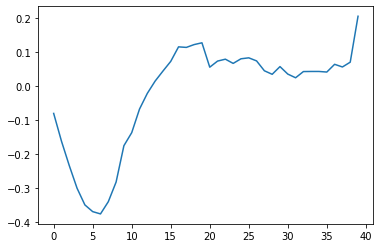

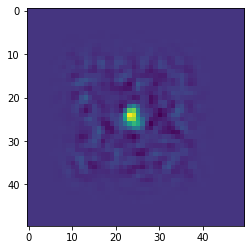

In [80]:
spatial, temporal = ft.decompose(sta)
plt.plot(temporal)
plt.show()
plt.imshow(spatial)
plt.show()

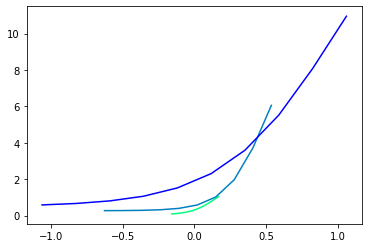

In [67]:
device = torch.device('cuda:0')
filt_depth = 40
cells='all'
cell = 0

cmap = plt.cm.get_cmap('winter')
colors = cmap(np.linspace(0, 1, 3))[::-1]

for idx, contrast in enumerate(np.linspace(0.05, 0.35, 3)):
    x = np.random.randn(1347,50,50) * contrast
    x = np.repeat(x, 3, axis=0)
    stimulus = x
    #x = (x + 1) * 127.5
    #x = (x - 51.8)/53.9
    x = 2.37 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
    
    layer_outs = inspect(model, x)
    responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))

    resp = responses[:, cell]
    sta = compute_sta(model, contrast, layer='ganglion', cell_index=cell, verbose=False)
    sta = np.flip(sta, axis=0)
    sta -= sta.mean()

    #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
    normed_sta = normalize_filter2(sta, stimulus)

    filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
    #nonlinearity = Binterp(40)
    nonlinearity = Sigmoid(peak=100.)
    nonlinearity.fit(filtered_stim[filt_depth:], resp[filt_depth:], maxfev=5000)

    x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
    nonlinear_prediction = nonlinearity.predict(x)
    spatial, temporal = ft.decompose(normed_sta)

    plt.plot(x, nonlinear_prediction, color=colors[idx])
    if temporal[10] < 0:
        temporal = -temporal
    #plt.plot(temporal, color=colors[idx])
plt.show()

In [44]:
TrainDataset(cfg).y.shape

(269975, 4)

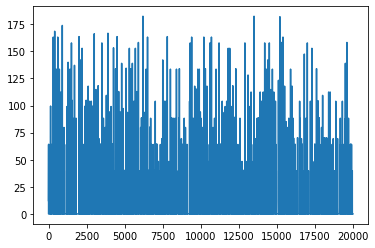

In [49]:
plt.plot(TrainDataset(cfg).y[-20000:, 2])

In [72]:
7//4

1